In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pprint import pprint

sns.set(style="whitegrid")

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_columns', None)

In [3]:
#Read in a bunch of csv files and stack them together

path =r'C:\\Users\\armcl\\Python\\Lending Club\\Data' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f,skiprows=[0],header=0,low_memory=False) for f in all_files)
lc_all   = pd.concat(df_from_each_file, ignore_index=True)

In [4]:
# number of loans and features in the raw data
lc_all.shape

(2778816, 150)

In [5]:
#Remove all NAs data
lc_all.dropna(subset=['loan_status'], inplace=True)

#int rate to numeric
lc_all['int_rate'] = pd.to_numeric(lc_all['int_rate'].str.replace("%", "").str.replace(" ", ""))

#Extract the initiation year feature
lc_all['issue_d'] = pd.to_datetime(lc_all['issue_d'])
lc_all['last_pymnt_d'] = pd.to_datetime(lc_all['last_pymnt_d'])
lc_all['issue_y'] = lc_all['issue_d'].dt.year


C:\Users\armcl\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


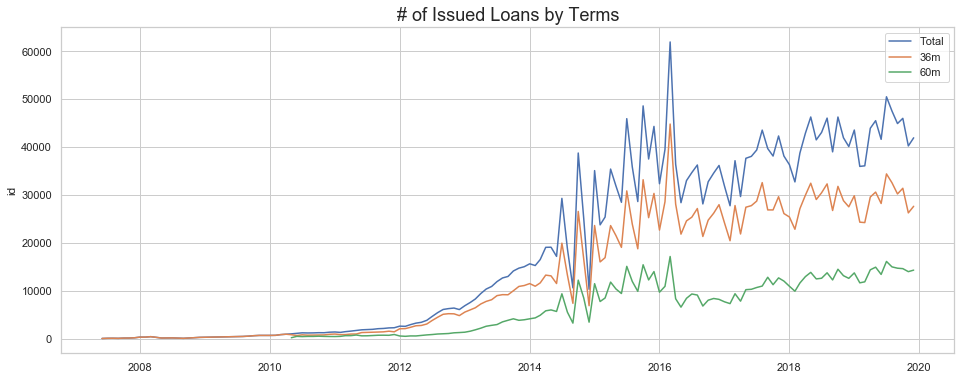

In [6]:
#Size of the issued loans over time
#The 2016 drop is intresting, there was a Lending Club scandal back then
#Num of Grade A loans plumetted and took a long time to finally come back

num_issue = lc_all.groupby('issue_d').count()

#By terms
num_issue_36m = lc_all[lc_all['term']==' 36 months'].groupby('issue_d').count()
num_issue_60m = lc_all[lc_all['term']==' 60 months'].groupby('issue_d').count()

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=num_issue.index, y="id", label = 'Total', data=num_issue)
ax = sns.lineplot(x=num_issue_36m.index, y="id", label = '36m', data=num_issue_36m)
ax = sns.lineplot(x=num_issue_60m.index, y="id", label = '60m', data=num_issue_60m)

ax.set_xlabel('')
ax.set_title("# of Issued Loans by Terms", fontsize=18)
plt.show()

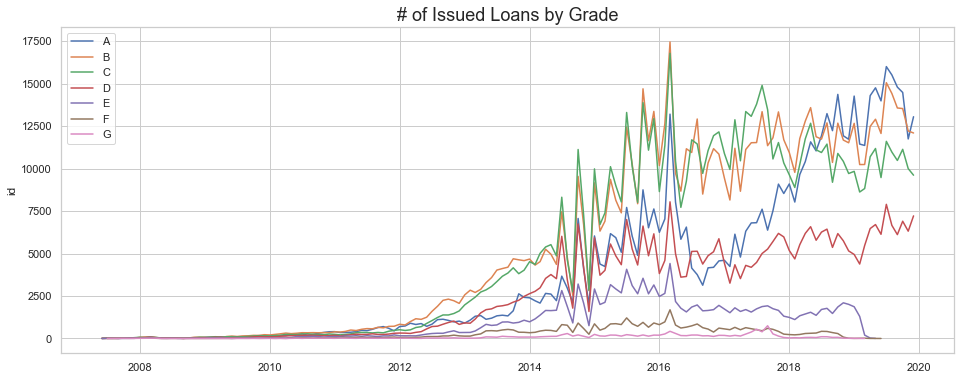

In [7]:
#By grade
num_issue_A = lc_all[lc_all['grade']=='A'].groupby('issue_d').count()
num_issue_B = lc_all[lc_all['grade']=='B'].groupby('issue_d').count()
num_issue_C = lc_all[lc_all['grade']=='C'].groupby('issue_d').count()
num_issue_D = lc_all[lc_all['grade']=='D'].groupby('issue_d').count()
num_issue_E = lc_all[lc_all['grade']=='E'].groupby('issue_d').count()
num_issue_F = lc_all[lc_all['grade']=='F'].groupby('issue_d').count()
num_issue_G = lc_all[lc_all['grade']=='G'].groupby('issue_d').count()

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=num_issue_A.index, y="id", label = 'A', data=num_issue_A)
ax = sns.lineplot(x=num_issue_B.index, y="id", label = 'B', data=num_issue_B)
ax = sns.lineplot(x=num_issue_C.index, y="id", label = 'C', data=num_issue_C)
ax = sns.lineplot(x=num_issue_D.index, y="id", label = 'D', data=num_issue_D)
ax = sns.lineplot(x=num_issue_E.index, y="id", label = 'E', data=num_issue_E)
ax = sns.lineplot(x=num_issue_F.index, y="id", label = 'F', data=num_issue_F)
ax = sns.lineplot(x=num_issue_G.index, y="id", label = 'G', data=num_issue_G)

ax.set_xlabel('')
ax.set_title("# of Issued Loans by Grade", fontsize=18)
plt.show()

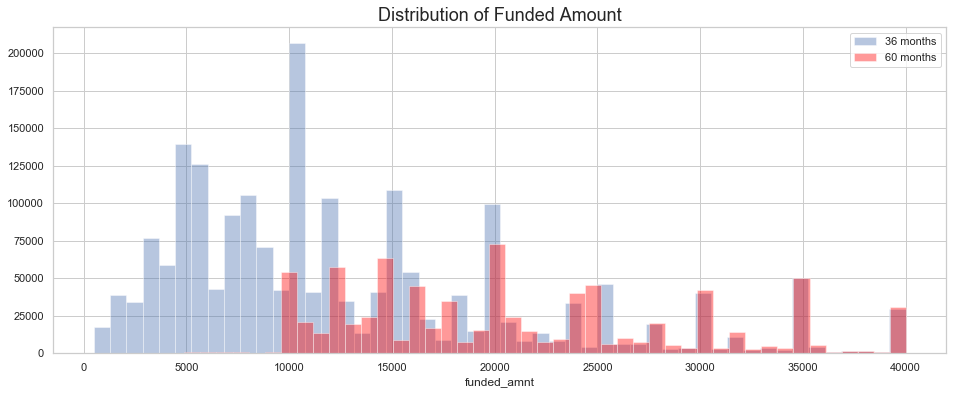

In [8]:
#Plot the distribution of funded amount
#It ranges from $1,000 to $40,000 with a median $13,000
#Interesting to see the peaks at rounded numbers like $10K, $20K, $30K
plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all.loc[lc_all['term']==' 36 months','funded_amnt'],kde=False,label='36 months')
ax = sns.distplot(lc_all.loc[lc_all['term']==' 60 months','funded_amnt'],kde=False,label='60 months',color='red')
ax.set_title("Distribution of Funded Amount", fontsize=18)
plt.legend()
plt.show()

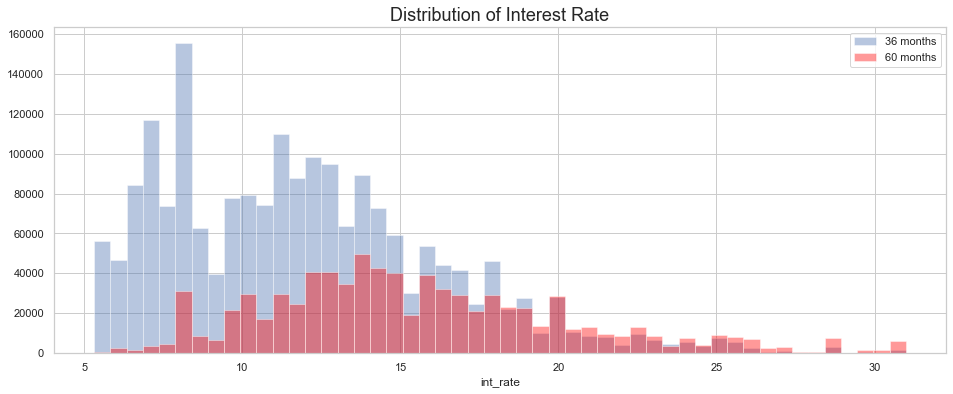

In [9]:
#Plot the distribution of interest rate
#Long tails on the right
#It ranges from 5.31% to 30.99% with a median of 12.7%
#interest rate on the 60 months loan is higher similar to the yield curve to account for the risks

plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all.loc[lc_all['term']==' 36 months','int_rate'],kde=False,label='36 months')
ax = sns.distplot(lc_all.loc[lc_all['term']==' 60 months','int_rate'],kde=False,label='60 months',color='red')
ax.set_title("Distribution of Interest Rate", fontsize=18)
plt.legend()
plt.show()

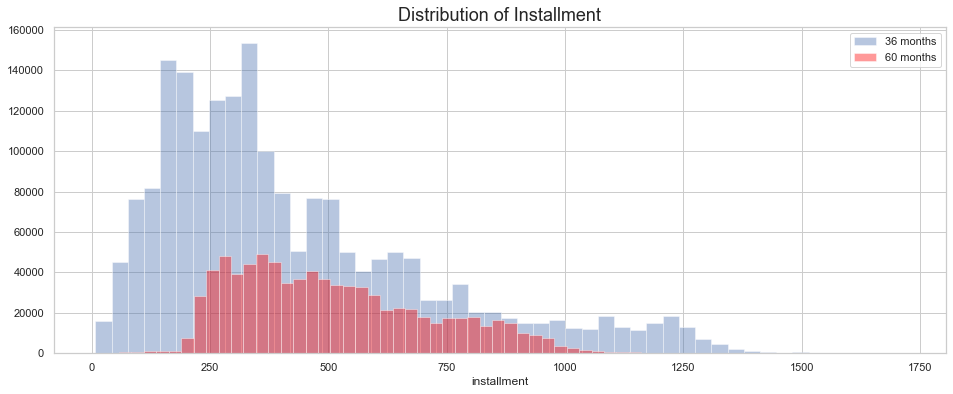

In [10]:
#Plot the distribution of installment
#Long tails on the right
#It ranges from $4.93 to $1719.83 with a median of $377.42
#36 months installment is more spread out simply because of more observations

plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all.loc[lc_all['term']==' 36 months','installment'],kde=False,label='36 months')
ax = sns.distplot(lc_all.loc[lc_all['term']==' 60 months','installment'],kde=False,label='60 months',color='red')
ax.set_title("Distribution of Installment", fontsize=18)
plt.legend()
plt.show()

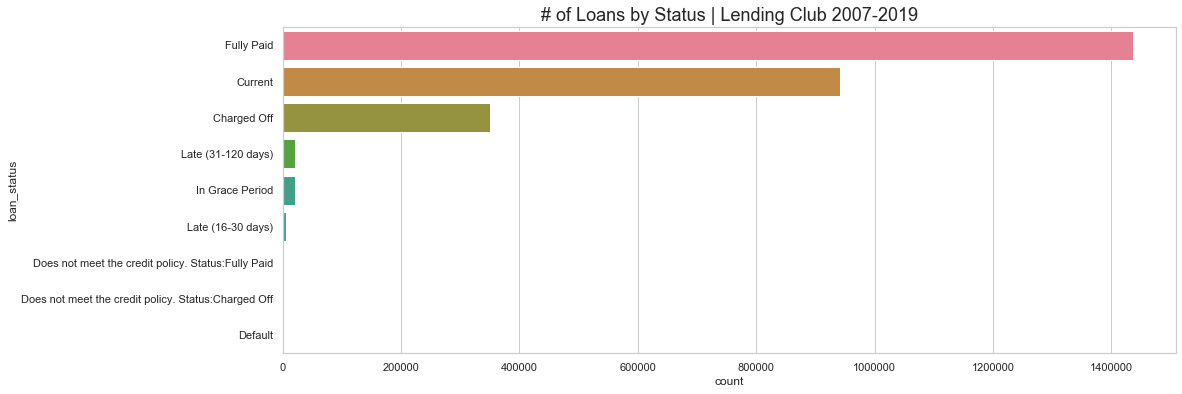

In [11]:
#Number of loans by status from 2007 to 2019
#Only include fully paid and charged off loans in the default prediction model
#Because we don't know the final status for current loans yet

plt.figure(figsize=(16, 6))
ax = sns.countplot(y="loan_status", data=lc_all, palette = 'husl',order = lc_all['loan_status'].value_counts().index)
ax.set_title("# of Loans by Status | Lending Club 2007-2019", fontsize=18)
plt.show()

#Defaulted loans are tiny and let's relabel them to charge off
lc_all['loan_status'].replace({'Default':'Charged Off'}, inplace=True)

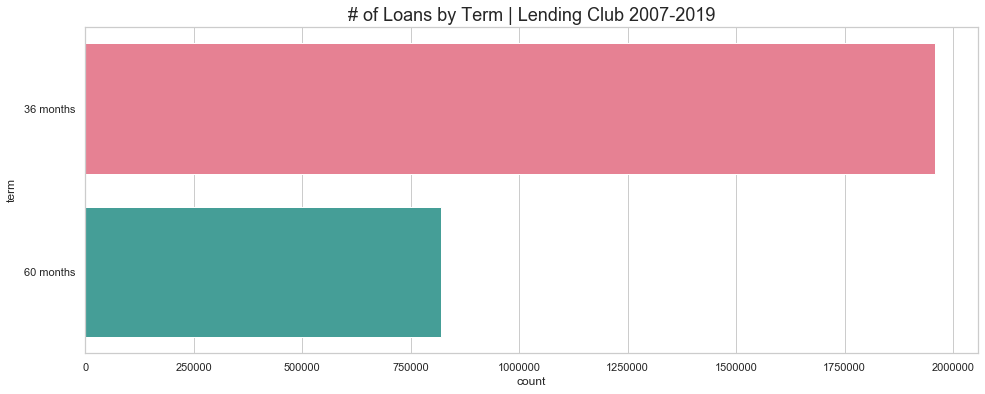

In [12]:
#Count of loans by terms from 2007 to 2019

plt.figure(figsize=(16, 6))
ax = sns.countplot(y="term", data=lc_all, palette = 'husl')
ax.set_title("# of Loans by Term | Lending Club 2007-2019", fontsize=18)
plt.show()

In [13]:
#The median funded amount for 60 months loan is almost twice as high as that of 36 months
#The interest rate is also higher for 60 months probabaly because of 2 reasons:
#1) longer marutiry higher risks
#2) people with lower credit score like higher maturity to lower their installment

lc_all.groupby('term').median()[['funded_amnt','int_rate','installment']]

,funded_amnt,int_rate,installment
term,,,
36 months,10000.0,11.49,339.39
60 months,20000.0,14.99,471.77


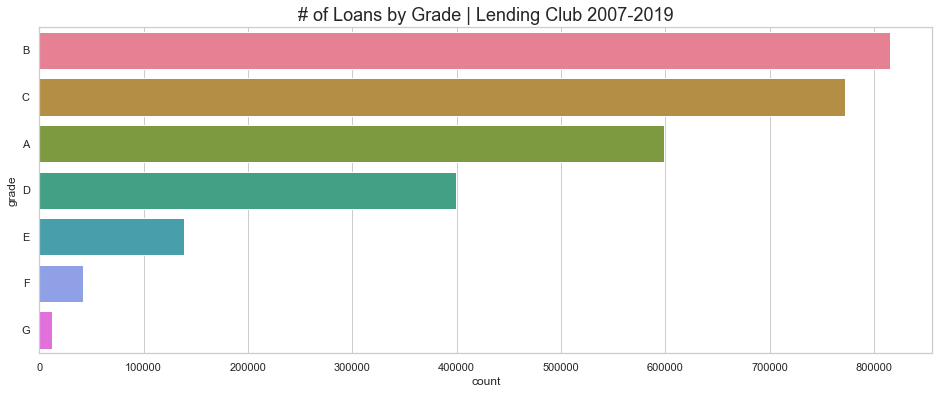

In [14]:
#Count of loans by grade from 2007 to 2019
#The loan grade is the result of a formula that takes into account not only credit score, 
#but also a combination of several indicators of credit risk from the credit report and loan application. 
#All loans have either a 36- or 60-month term, with fixed interest rates and equal payments.

plt.figure(figsize=(16, 6))
ax = sns.countplot(y="grade", data=lc_all, palette = 'husl', order=lc_all['grade'].value_counts().index)
ax.set_title("# of Loans by Grade | Lending Club 2007-2019", fontsize=18)
plt.show()

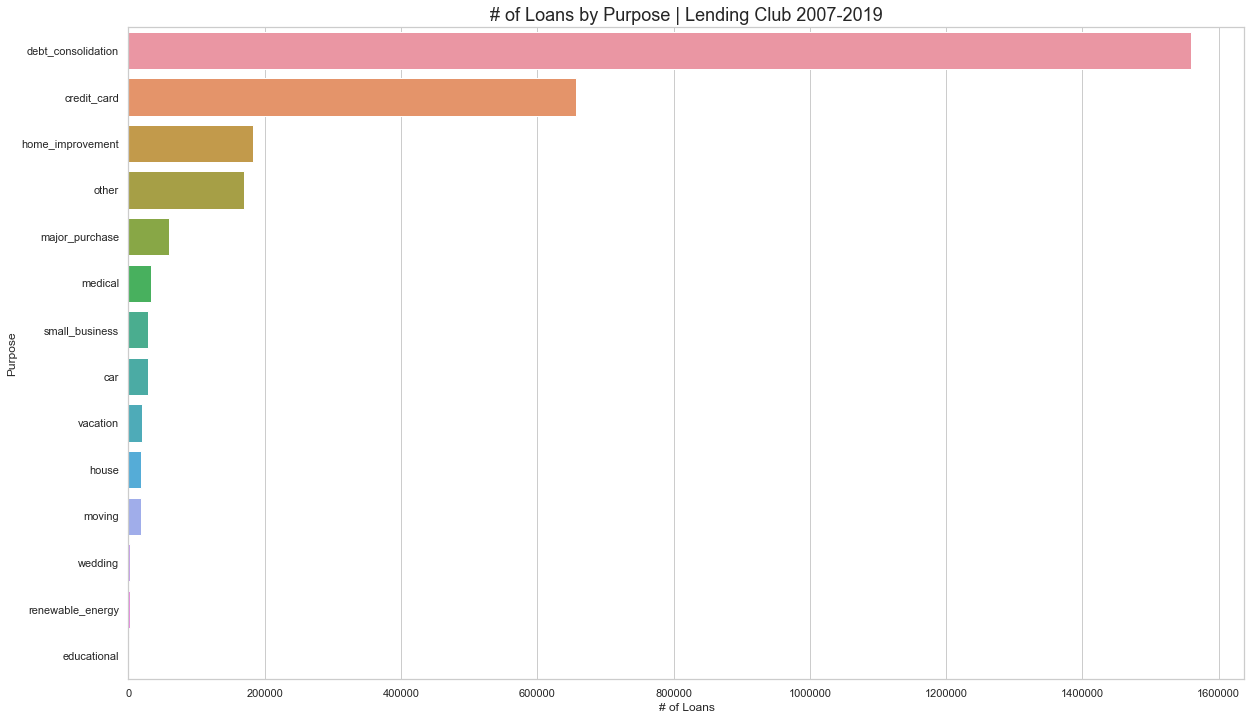

In [15]:
#Number of loans by purpose
loan_purpose_count = lc_all.groupby('purpose').count().sort_values('funded_amnt',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_purpose_count.funded_amnt, y=loan_purpose_count.index)

# Add labels to your graph
plt.xlabel('# of Loans')
plt.ylabel('Purpose')
plt.title("# of Loans by Purpose | Lending Club 2007-2019", fontsize=18)
plt.show()

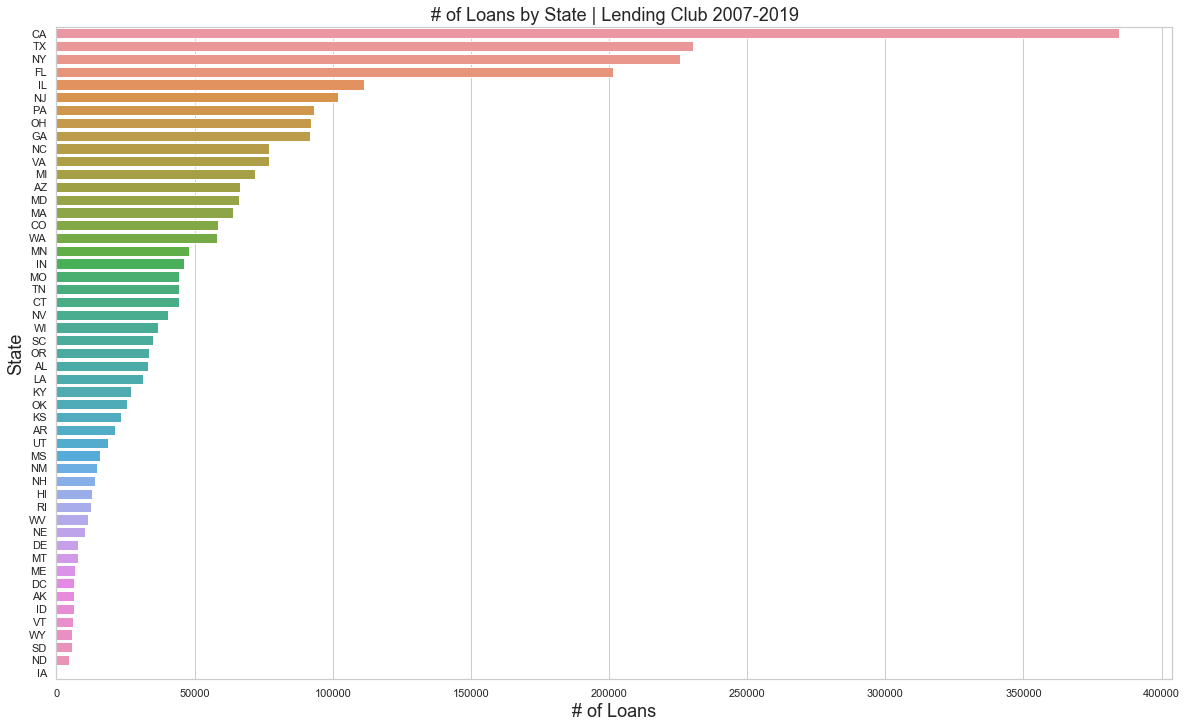

In [16]:
#Number of loans by state
loan_purpose_count = lc_all.groupby('addr_state').count().sort_values('funded_amnt',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_purpose_count.funded_amnt, y=loan_purpose_count.index)

# Add labels to your graph
plt.xlabel('# of Loans', fontsize=18)
plt.ylabel('State', fontsize=18)
plt.title("# of Loans by State | Lending Club 2007-2019", fontsize=18)
plt.show()

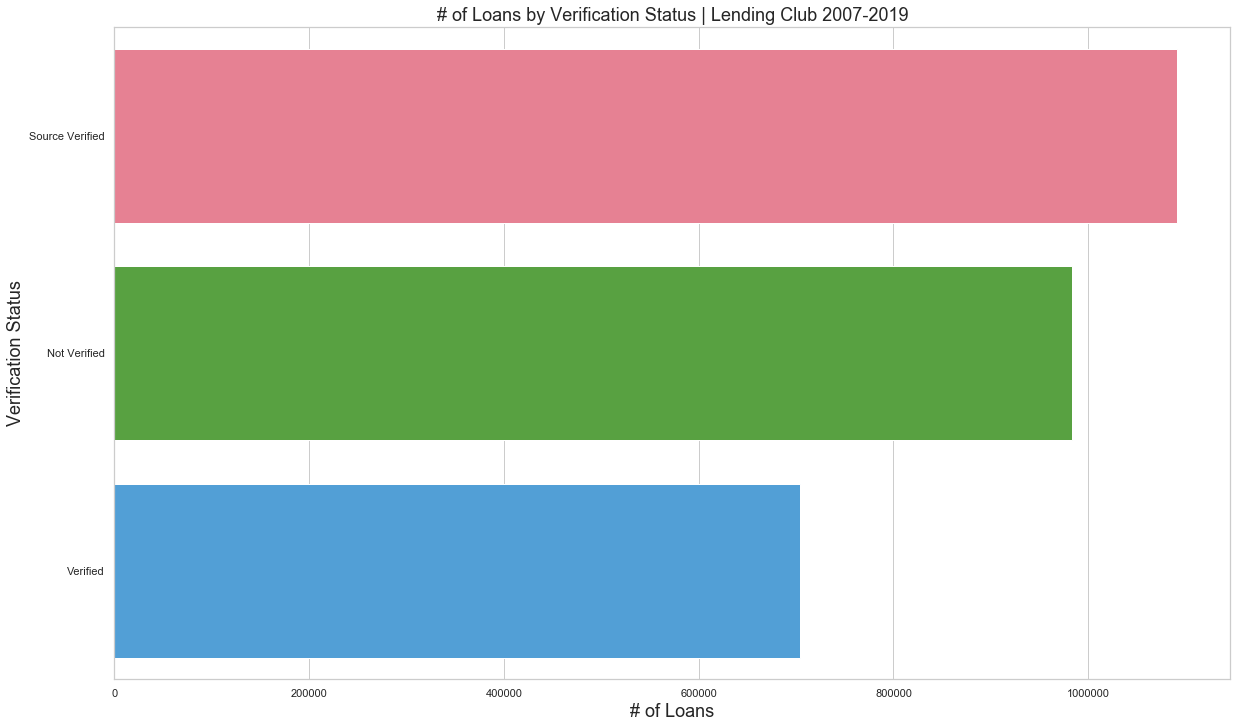

In [17]:
#Number of loans by verification status
loan_purpose_count = lc_all.groupby('verification_status').count().sort_values('funded_amnt',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_purpose_count.funded_amnt,  palette = 'husl', y=loan_purpose_count.index)

# Add labels to your graph
plt.xlabel('# of Loans', fontsize=18)
plt.ylabel('Verification Status', fontsize=18)
plt.title("# of Loans by Verification Status | Lending Club 2007-2019", fontsize=18)
plt.show()

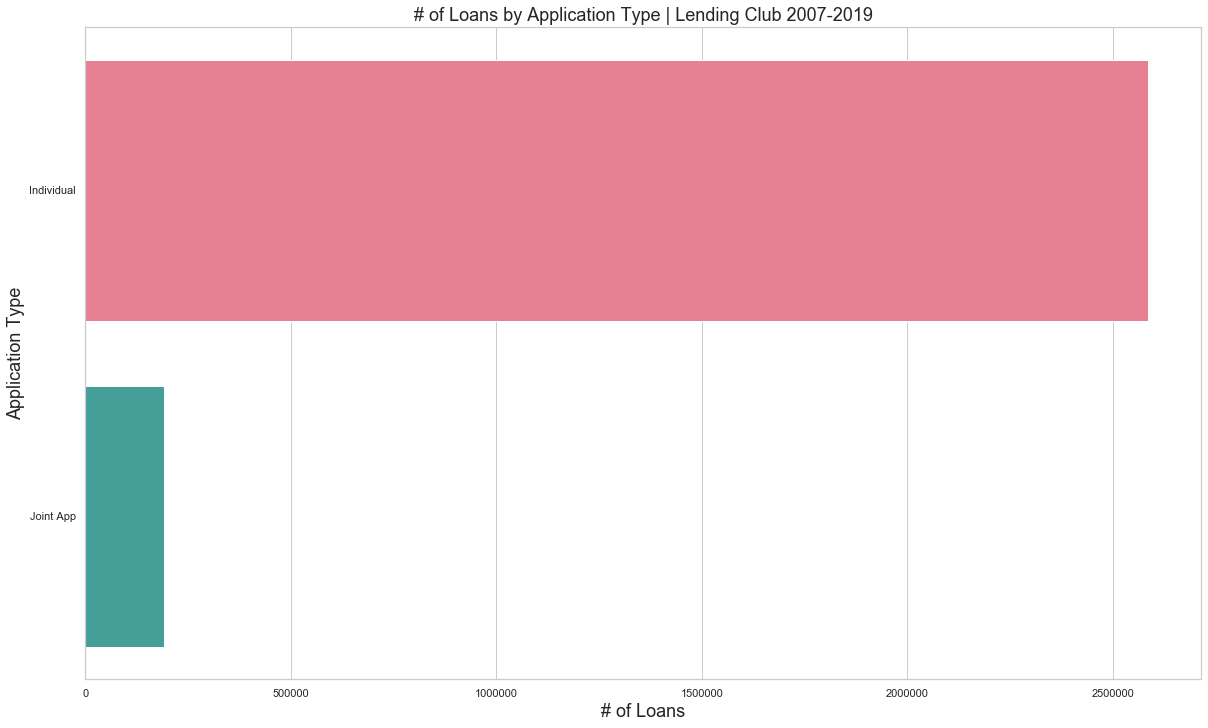

In [18]:
#Number of loans by application type
loan_purpose_count = lc_all.groupby('application_type').count().sort_values('funded_amnt',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_purpose_count.funded_amnt,  palette = 'husl', y=loan_purpose_count.index)

# Add labels to your graph
plt.xlabel('# of Loans', fontsize=18)
plt.ylabel('Application Type', fontsize=18)
plt.title("# of Loans by Application Type | Lending Club 2007-2019", fontsize=18)
plt.show()

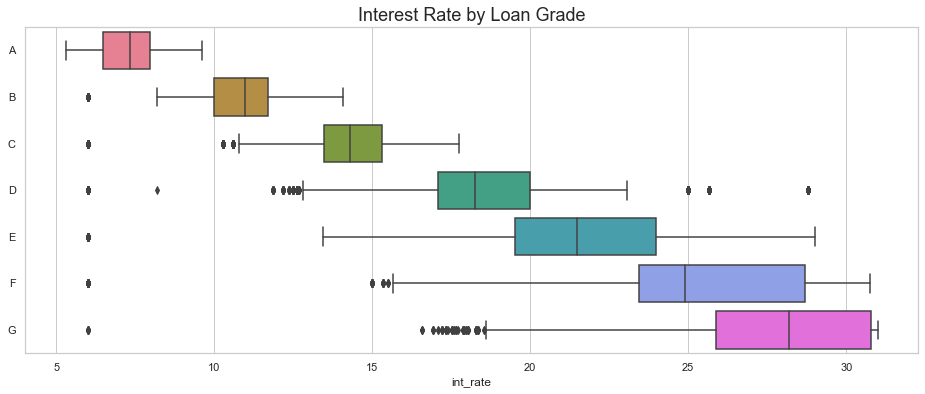

In [19]:
#Interest rate by group
#The 6% interest rate for almost Grade B to G seems odd and artificial, need to look into this further

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="int_rate", y='grade', orient="h", palette = 'husl', data=lc_all.sort_values('grade'))
ax.set_title("Interest Rate by Loan Grade", fontsize=18)
ax.set_ylabel('')

plt.show()

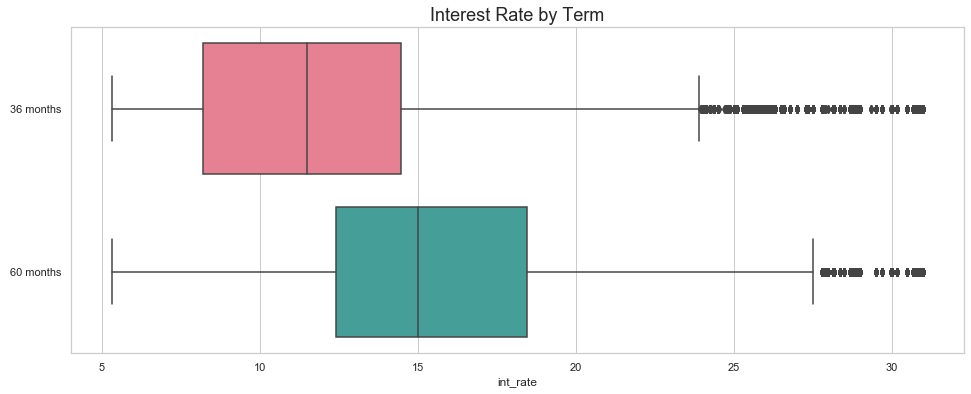

In [20]:
#Interest rate by term
#Higher interest rate for longer terms to reflect the higher risks and exposures

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="int_rate", y='term', orient="h", palette = 'husl', data=lc_all.sort_values('term'))
ax.set_title("Interest Rate by Term", fontsize=18)
ax.set_ylabel('')

plt.show()

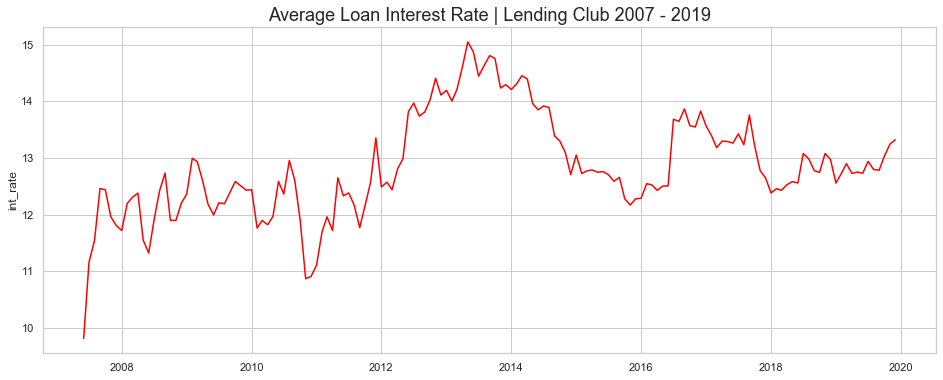

In [21]:
#Time Series of Loan Interest Rate
#Lending Club’s interest rates take into account credit risk and market conditions. 
#The final interest rate for each loan grade is the result of the following equation:
#Lending Club Base Rate + Adjustment for Risk & Volatility

int_rate_mean = lc_all.groupby('issue_d').mean()

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=int_rate_mean.index, y="int_rate", color = "red", data=int_rate_mean)

#plt.xticks(agg_logins_mean.index, rotation=45)
ax.set_xlabel('')
ax.set_title("Average Loan Interest Rate | Lending Club 2007 - 2019", fontsize=18)
plt.show()

In [22]:
#Current loans are not necessarily going to be fully paid
#Only include loans that are either fully paid or charged off in this analysis

lc_all = lc_all.loc[lc_all['loan_status'].isin(['Fully Paid','Charged Off']),:]

In [23]:
#Avoid data leakage (remove features that were unknown at the time of the loan initiaion)
leakage_features = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high',
                    'last_fico_range_low','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',
                    'num_tl_120dpd_2m','num_tl_30dpd','out_prncp','out_prncp_inv',
                    'recoveries','total_pymnt','total_pymnt_inv','total_rec_int',
                    'total_rec_late_fee','total_rec_prncp','debt_settlement_flag',
                    'debt_settlement_flag_date','settlement_status','settlement_date',
                    'settlement_amount','settlement_percentage','settlement_term']

#Remove features that don't have much added information
#For example sub_grade is finer than grade
features_to_remove = leakage_features + ['emp_title','loan_amnt','funded_amnt_inv','grade',
                                         'id','member_id','title','url','zip_code',
                                         'pymnt_plan','policy_code']

lc_all = lc_all.drop(columns=features_to_remove)


In [24]:
#If join application, replace with the joint info

lc_all['revol_util'] = pd.to_numeric(lc_all['revol_util'].str.replace("%", ""))

lc_all.loc[lc_all['application_type']=='Joint App','annual_inc'] = lc_all.loc[lc_all['application_type']=='Joint App','annual_inc_joint']
lc_all.loc[lc_all['application_type']=='Joint App','dti'] = lc_all.loc[lc_all['application_type']=='Joint App','dti_joint']
lc_all.loc[lc_all['application_type']=='Joint App','verification_status'] = lc_all.loc[lc_all['application_type']=='Joint App','verification_status_joint']

lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['revol_bal_joint'].isnull()),'revol_bal'] = lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['revol_bal_joint'].isnull()),'revol_bal_joint']
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'fico_range_low'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'fico_range_low'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'sec_app_fico_range_low'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'fico_range_high'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'fico_range_high'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'sec_app_fico_range_high'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'sec_app_inq_last_6mths'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'mort_acc'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'mort_acc'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'sec_app_mort_acc'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'open_acc'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'open_acc'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'sec_app_open_acc'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'revol_util'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'revol_util'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'sec_app_revol_util'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'open_act_il'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'open_act_il'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'sec_app_open_act_il'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'sec_app_num_rev_accts'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'sec_app_chargeoff_within_12_mths'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'sec_app_collections_12_mths_ex_med'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'sec_app_mths_since_last_major_derog'])/2

In [25]:
#Reduce the number of categories for home ownership
lc_all = lc_all.replace({'home_ownership' : {'ANY':'OTHER','NONE':'OTHER'}})

#Create dummy variables

lc_all = pd.concat([lc_all, lc_all['term'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, lc_all['sub_grade'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['home_ownership'],prefix="Home")], axis=1)
lc_all = pd.concat([lc_all, lc_all['verification_status'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['purpose'],prefix="purpose")], axis=1)
lc_all = pd.concat([lc_all, lc_all['addr_state'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['initial_list_status'],prefix="list_status")], axis=1)
lc_all = pd.concat([lc_all, lc_all['application_type'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, lc_all['loan_status'].str.get_dummies(sep=',')], axis=1)

In [26]:
#Replace categorical variables to numerical
lc_all = lc_all.replace({'emp_length' : {'< 1 year':0.5,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':15}})

#Create a few new features

lc_all['loan_desc_length'] = lc_all['desc'].str.len().fillna(0)

lc_all['earliest_cr_line'] = pd.to_datetime(lc_all['earliest_cr_line'])
lc_all['cr_line_months'] = lc_all['issue_d'] - lc_all['earliest_cr_line']
lc_all['cr_line_months']=round(lc_all['cr_line_months']/np.timedelta64(1,'M'),2)

lc_all['sec_app_earliest_cr_line'] = pd.to_datetime(lc_all['sec_app_earliest_cr_line'])
lc_all['sec_app_cr_line_months'] = lc_all['issue_d'] - lc_all['sec_app_earliest_cr_line']
lc_all['sec_app_cr_line_months']=round(lc_all['sec_app_cr_line_months']/np.timedelta64(1,'M'),2)

lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'cr_line_months'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'cr_line_months'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'sec_app_cr_line_months'])/2

lc_all['fico_range_avg'] = (lc_all['fico_range_low'] + lc_all['fico_range_high'])/2

#And remove the joint data
features_to_remove = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths',
                      'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                      'sec_app_mths_since_last_major_derog','sec_app_cr_line_months',
                      'sec_app_earliest_cr_line']

lc_all = lc_all.drop(columns=features_to_remove)

In [27]:
#No hardship application for paid off and charged off loans, remove the irrelvant features
lc_all = lc_all.drop(lc_all.loc[:, 'hardship_flag':'hardship_last_payment_amount'].columns, axis = 1) 

#remove new features with data only after 2015
#can't fill the NaNs before 2015 since it's not randomly missing
#might worth only looking at the post 2015 data and see if any of these are important
lc_all = lc_all.drop(columns=['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
                       'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                       'all_util','inq_fi','total_cu_tl','inq_last_12m'])

In [28]:
percent_missing = lc_all.isnull().sum() * 100 / len(lc_all)
missing_value_df = pd.DataFrame({'column_name': lc_all.columns,
                                 'percent_missing': percent_missing})

#remove features with more than 40% missing values
missing_features = missing_value_df.loc[missing_value_df['percent_missing']>40,'column_name'].to_list()

lc_all = lc_all.drop(columns=missing_features)

In [29]:
#Fill Nas
#For these features, the longer the better

features_to_inverse = ['mths_since_recent_inq','mo_sin_old_il_acct',
                  'mo_sin_old_rev_tl_op']

for col in features_to_inverse:
    lc_all[col] = lc_all[col].fillna(2*lc_all[col].max())
    
#Remove all NAs data
lc_all.dropna(subset=['tot_coll_amt'], inplace=True)

#Features from open_acc_6m to inq_last_12m are new features released after 2015
#Use median for the 2007-2018 sample; worth only looking at the 2015-2018 sample to see if any significance

replace_median = ['dti','inq_last_6mths','revol_util',
                  'emp_length',
                  'bc_open_to_buy','avg_cur_bal','mo_sin_rcnt_rev_tl_op',
                  'bc_util','chargeoff_within_12_mths','mths_since_recent_bc','num_rev_accts',
                  'pct_tl_nvr_dlq','percent_bc_gt_75'
                  ]

for col in replace_median:
    lc_all[col] = lc_all[col].fillna(lc_all[col].median())


In [30]:
#Drop state dummy variables with less than 10000 loans in the data

bystate = lc_all.groupby('addr_state').count().sort_values('funded_amnt',ascending=False)
small_state = list(bystate[bystate['funded_amnt']<10000].index)
lc_all = lc_all.drop(columns=small_state)

In [31]:
#Some extreme values for annual income
#If it's too low like $2000 it might be applicants accidentally put in monthly income
#If it's too high like $110,000,000 it might be fake or erronous numbers
#We need to do some adjustments for the outliers
lc_all['annual_inc'].quantile([0,.0001,.01, .1, .25, .5, .75, .9, .99,.9999,1])

0.0000         2000.0
0.0001         8000.0
0.0100        19180.0
0.1000        35000.0
0.2500        48000.0
0.5000        67000.0
0.7500        95000.0
0.9000       132374.2
0.9900       275000.0
0.9999      1800000.0
1.0000    110000000.0
Name: annual_inc, dtype: float64

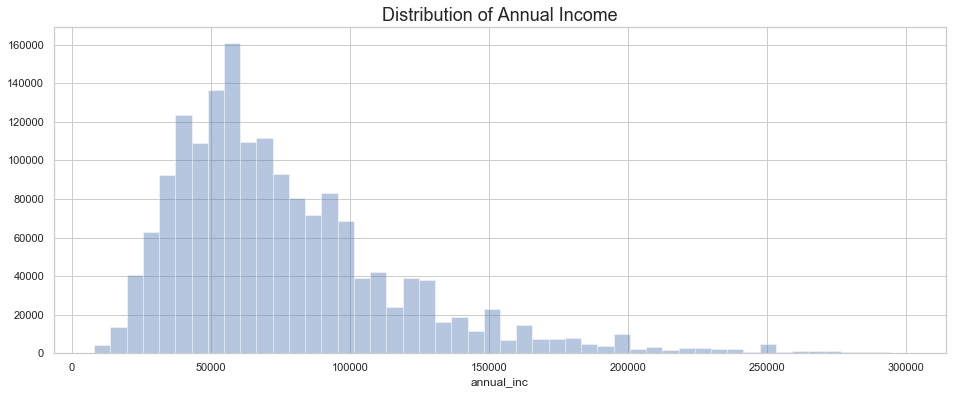

In [32]:
#Remove observations with annual income lower than $8000 and higher than $300k
lc_all = lc_all.loc[(lc_all['annual_inc'] > 8000) & (lc_all['annual_inc'] < 300000),:]

#Plot the distribution of annual income

plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all['annual_inc'],kde=False)
ax.set_title("Distribution of Annual Income", fontsize=18)
plt.show()

In [33]:
#Create a new feature which is installment/annual income/12

lc_all['installment_to_inc'] = 100*lc_all['installment']/(lc_all['annual_inc']/12)

In [34]:
#DTI can't be negative

lc_all['dti'].quantile([0,.0001,.01, .1, .25, 1/3, .5, 2/3, .75, .9, .99,.9999,1])

0.000000    -1.000000
0.000100     0.000000
0.010000     1.960000
0.100000     7.490000
0.250000    12.000000
0.333333    14.000000
0.500000    17.800000
0.666667    21.870000
0.750000    24.230000
0.900000    29.790000
0.990000    37.610000
0.999900    48.739022
1.000000    69.490000
Name: dti, dtype: float64

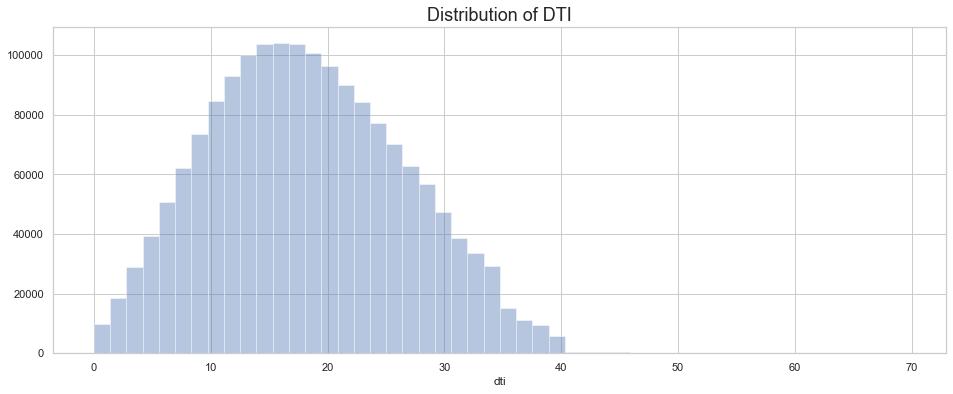

In [35]:
lc_all = lc_all.loc[lc_all['dti'] > 0,:]

#Plot the distribution of dti
#It resembles a bell curve really well with a long tail on the right

plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all['dti'],kde=False)
ax.set_title("Distribution of DTI", fontsize=18)
plt.show()

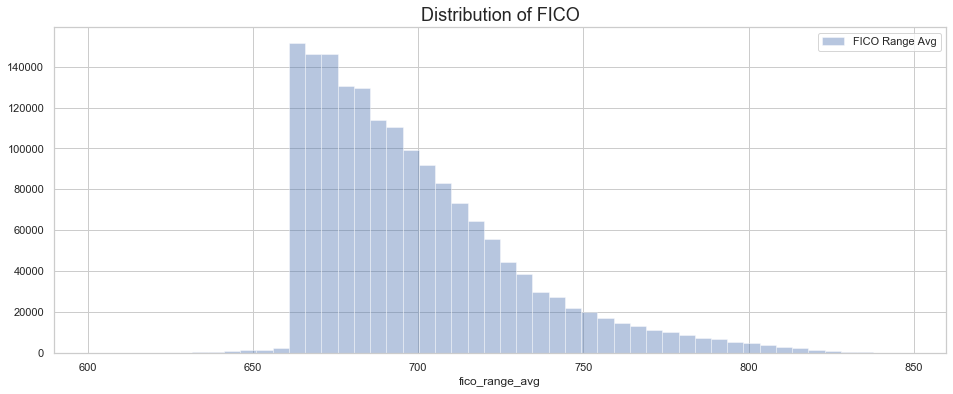

In [36]:
#Plot the distribution of FICO avg

plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all['fico_range_avg'],kde=False,label='FICO Range Avg')
ax.set_title("Distribution of FICO", fontsize=18)
plt.legend()
plt.show()

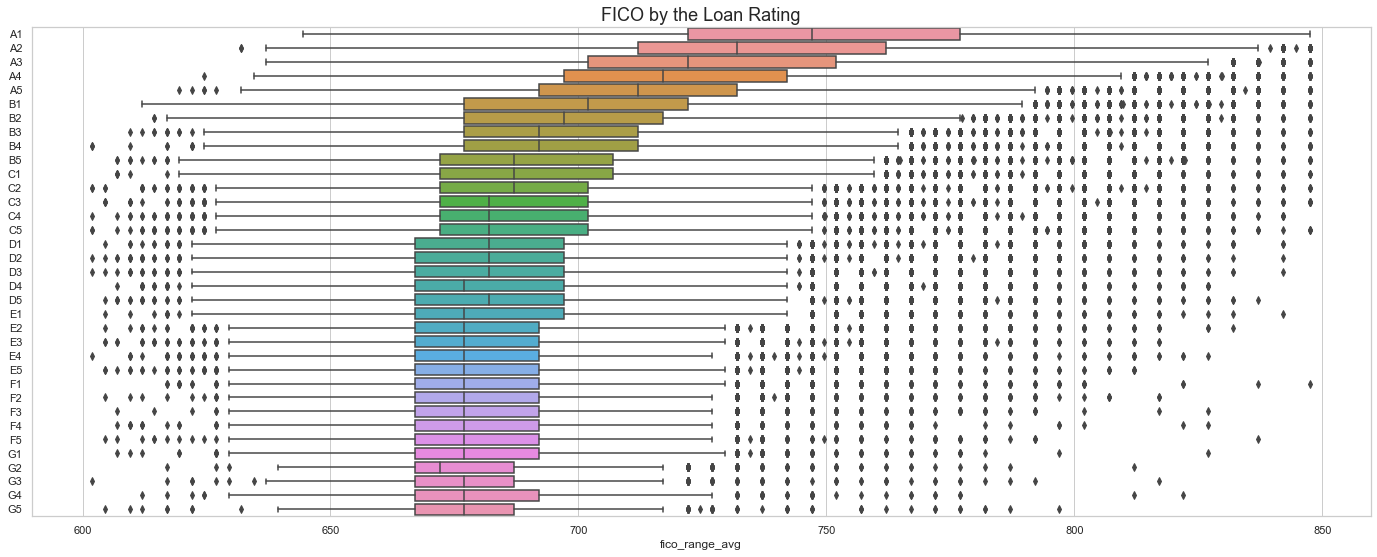

In [37]:
#FICO by sub group
#Note that sub group is decided by a combination of fico, loan applicant's information, loan purpose, loan term, and loan amount
#https://www.lendingclub.com/foliofn/rateDetail.action

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="fico_range_avg", y='sub_grade', orient="h", data=lc_all.sort_values('sub_grade'))
ax.set_title("FICO by the Loan Rating", fontsize=18)
ax.set_ylabel('')

plt.show()

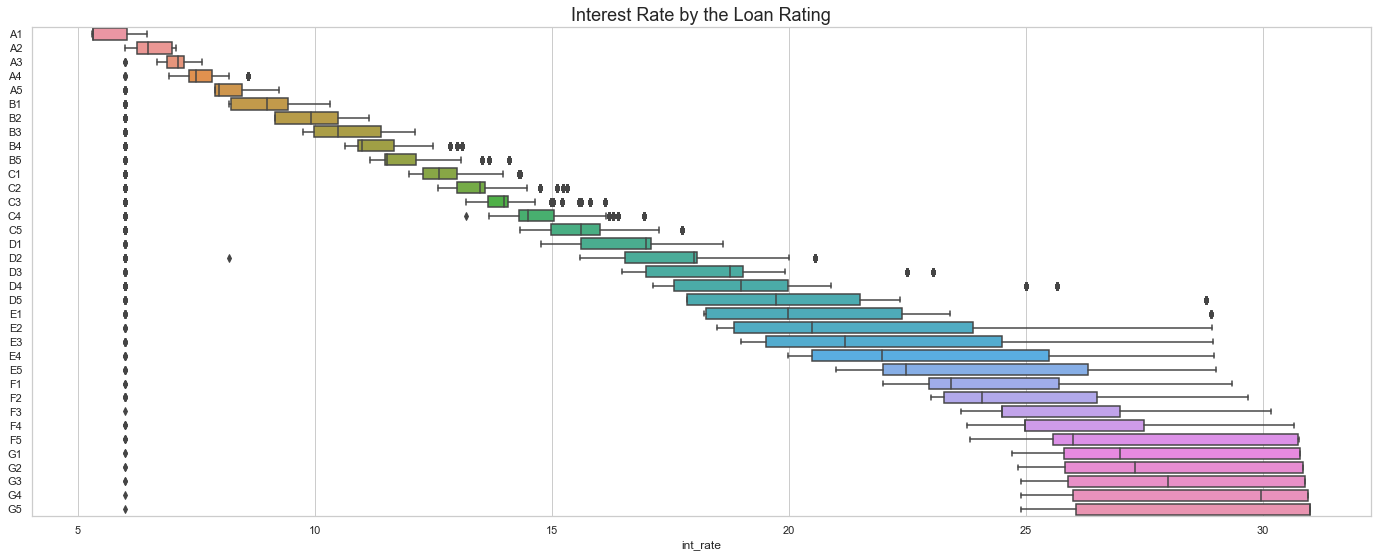

In [38]:
#Interest rate by sub group

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="int_rate", y='sub_grade', orient="h", data=lc_all.sort_values('sub_grade'))
ax.set_title("Interest Rate by the Loan Rating", fontsize=18)
ax.set_ylabel('')

plt.show()

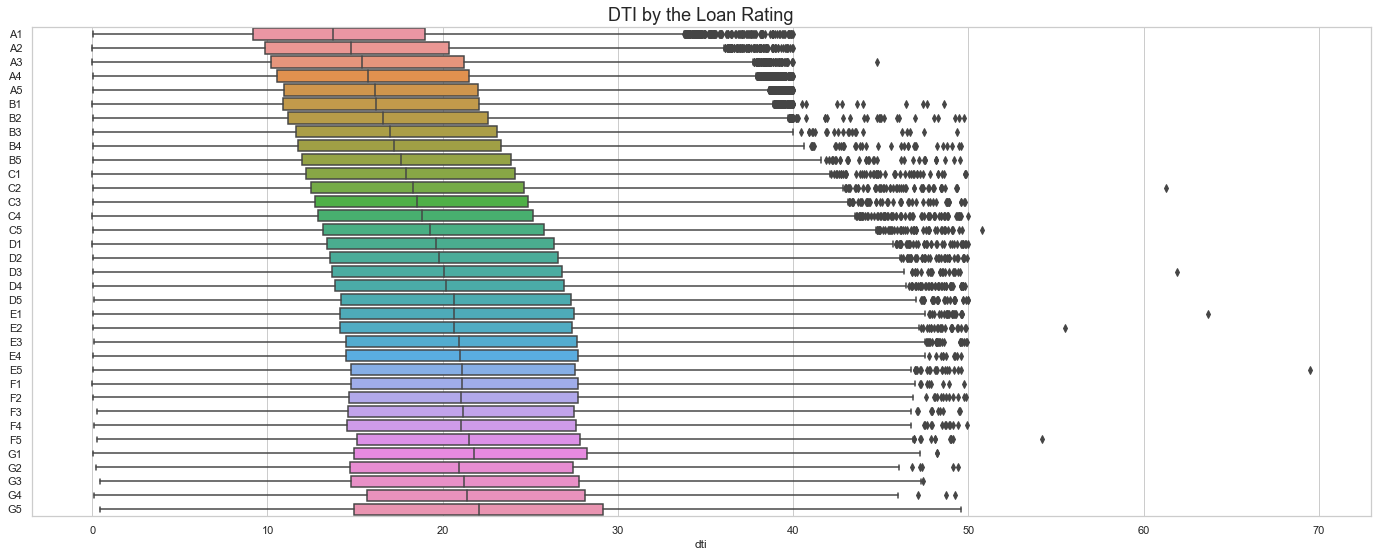

In [39]:
#DTI by sub group
#Note that sub group is decided by a combination of fico, loan applicant's information, loan purpose, loan term, and loan amount
#https://www.lendingclub.com/foliofn/rateDetail.action

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="dti", y='sub_grade', orient="h", data=lc_all.sort_values('sub_grade'))
ax.set_title("DTI by the Loan Rating", fontsize=18)
ax.set_ylabel('')

plt.show()

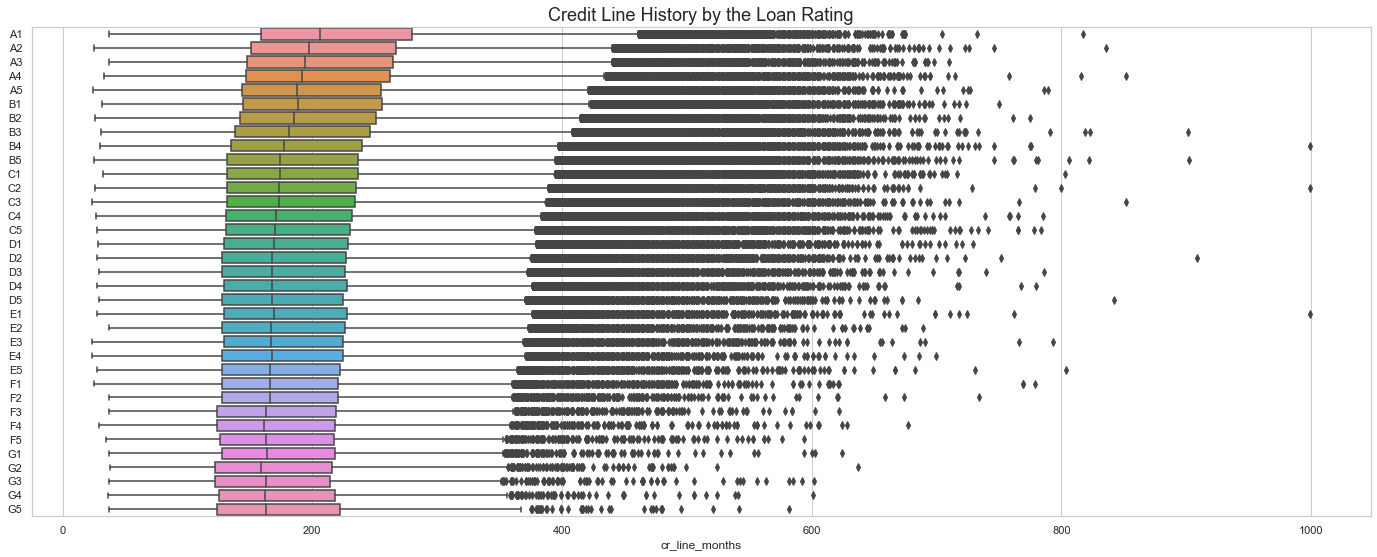

In [40]:
#cr_line_months by sub group
#Note that sub group is decided by a combination of fico, loan applicant's information, loan purpose, loan term, and loan amount
#https://www.lendingclub.com/foliofn/rateDetail.action

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="cr_line_months", y='sub_grade', orient="h", data=lc_all.sort_values('sub_grade'))
ax.set_title("Credit Line History by the Loan Rating", fontsize=18)
ax.set_ylabel('')

plt.show()

In [41]:
#Excluding current loans, on average about 20% of all loans were charged off

lc_all.loan_status.value_counts()/lc_all.loan_status.value_counts().sum()

Fully Paid     0.801494
Charged Off    0.198506
Name: loan_status, dtype: float64

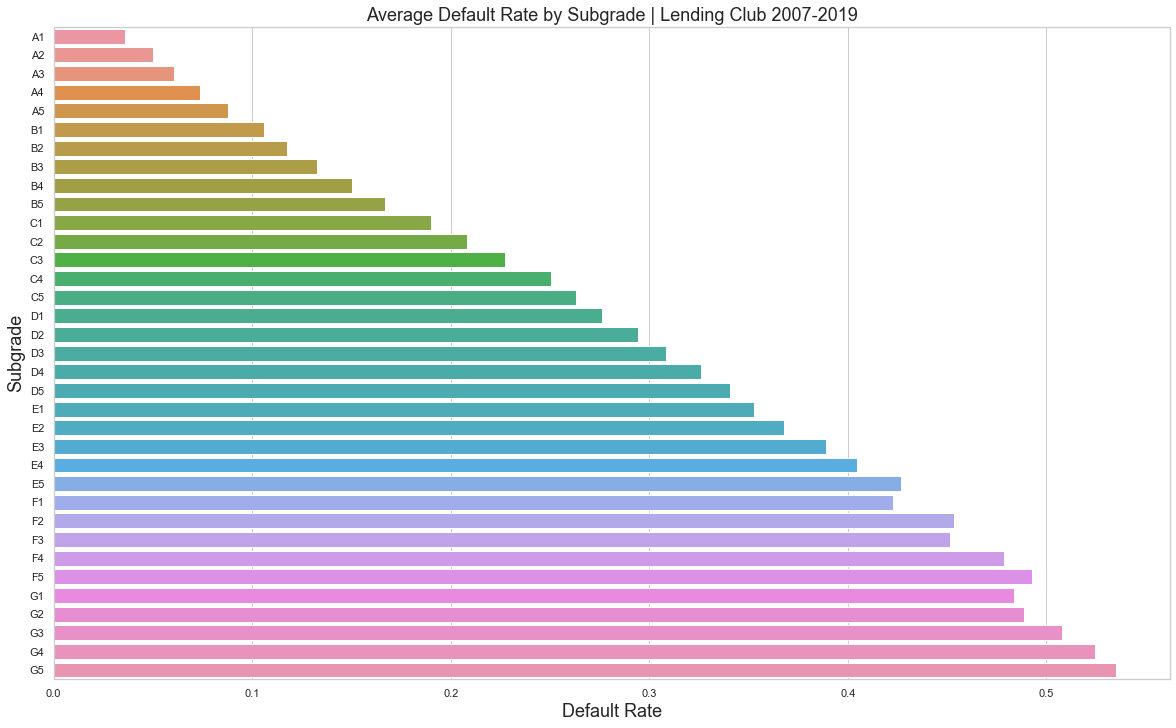

In [42]:
loan_status_by_grade = lc_all.groupby('sub_grade').mean()

#Default Rate by subgrade
plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_grade['Charged Off'], y=loan_status_by_grade.index)

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Subgrade', fontsize=18)
plt.title("Average Default Rate by Subgrade | Lending Club 2007-2019", fontsize=18)
plt.show()

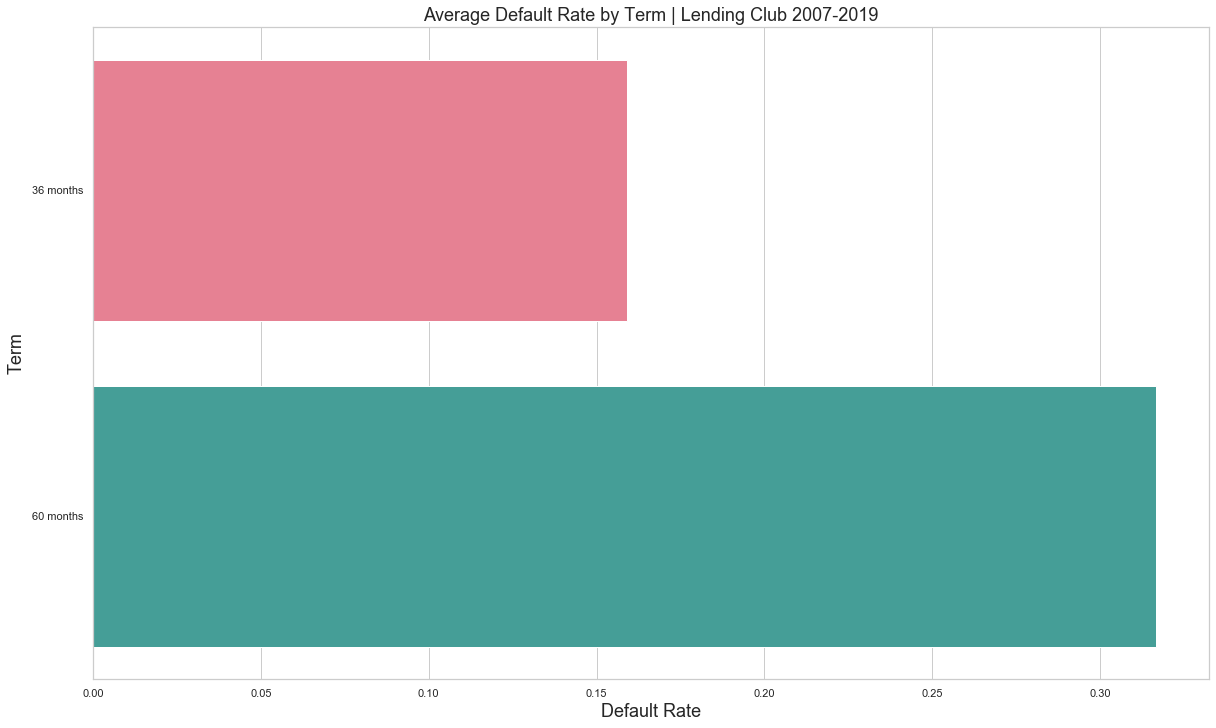

In [43]:
#Longer maturity is more likely to default

loan_status_by_term = lc_all.groupby('term').mean()

#Default Rate by term
plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_term['Charged Off'], y=loan_status_by_term.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Term', fontsize=18)
plt.title("Average Default Rate by Term | Lending Club 2007-2019", fontsize=18)
plt.show()

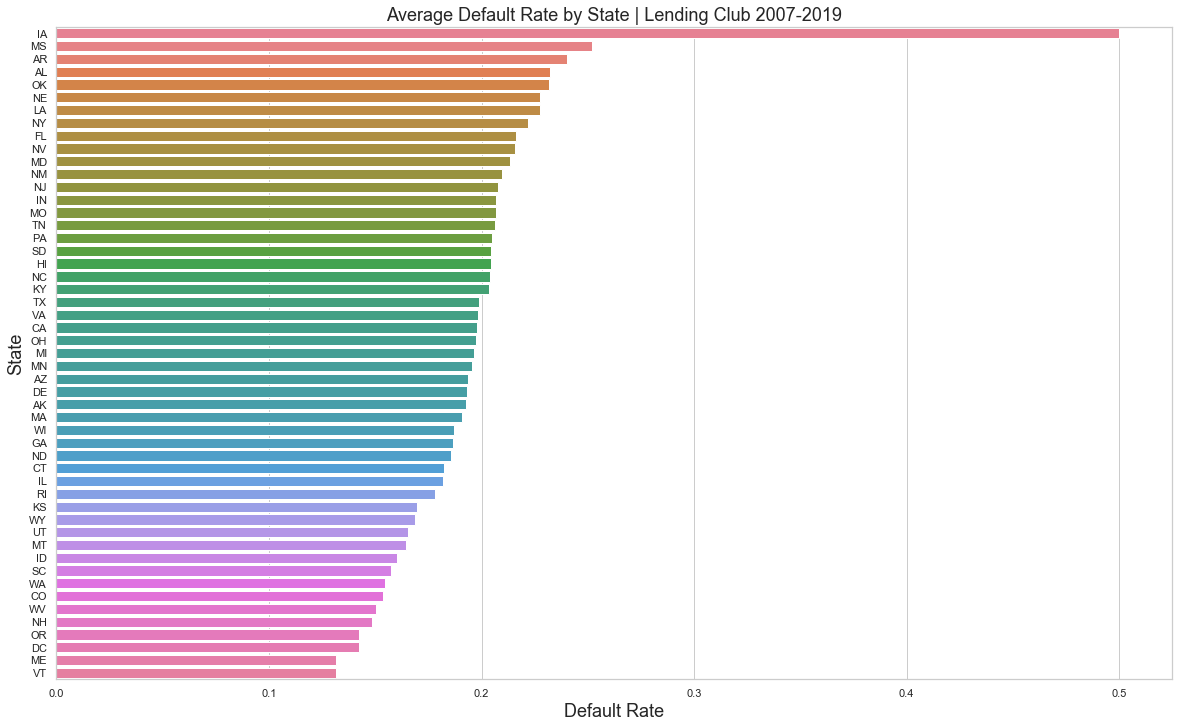

In [44]:
#Default Rate by state
#Be aware of the small sample size for many states/areas

loan_status_by_state = lc_all.groupby('addr_state').mean().sort_values('Charged Off',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_state['Charged Off'], y=loan_status_by_state.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('State', fontsize=18)
plt.title("Average Default Rate by State | Lending Club 2007-2019", fontsize=18)
plt.show()

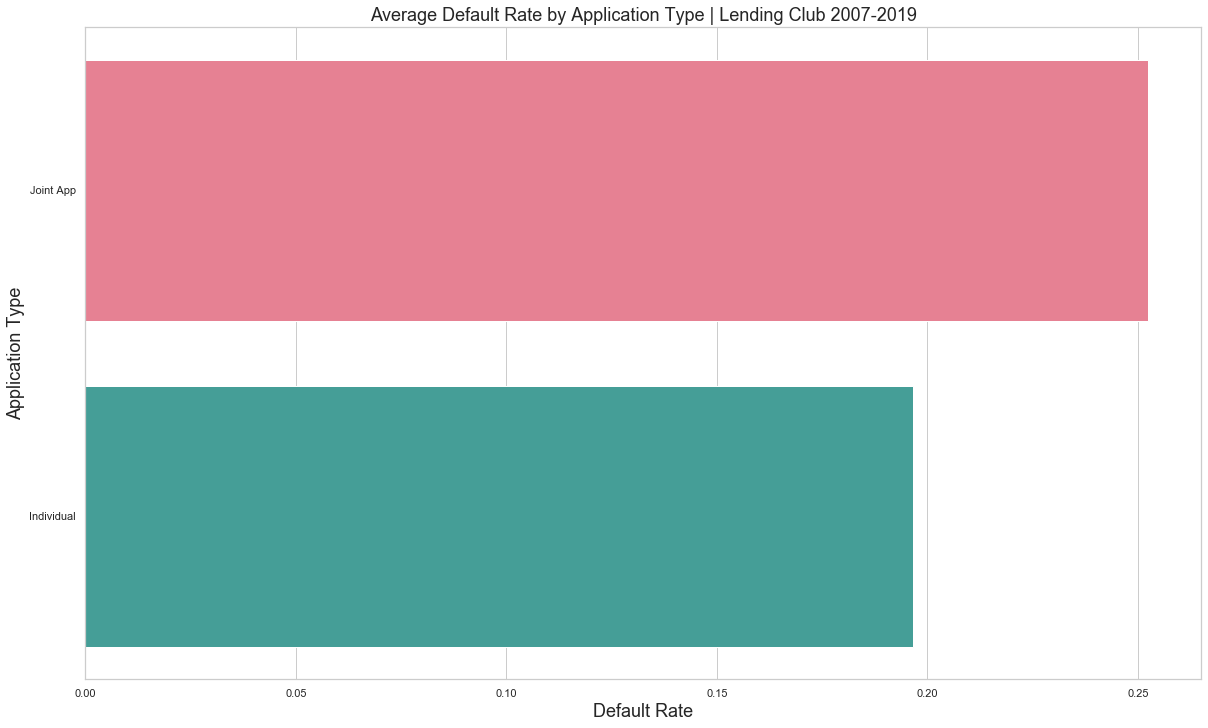

In [45]:
#Default Rate by application type
#WOW, this is interesting! Join applicants have higher default rate on average. Probably why they applied joinly.

loan_status_by_app_type = lc_all.groupby('application_type').mean().sort_values('Charged Off',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_app_type['Charged Off'], y=loan_status_by_app_type.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Application Type', fontsize=18)
plt.title("Average Default Rate by Application Type | Lending Club 2007-2019", fontsize=18)
plt.show()

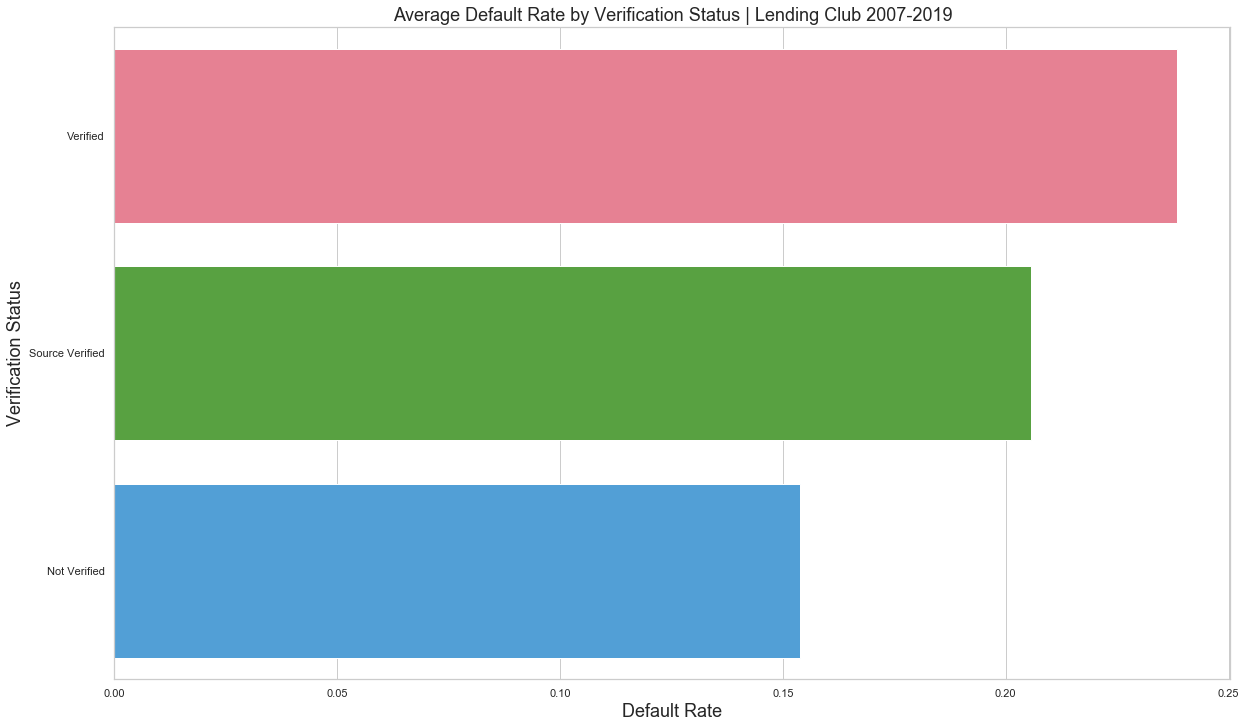

In [46]:
#Default Rate by verification status
#Also interesting! Applicants who need to be verified in the first place are more likely to default

loan_status_by_verify = lc_all.groupby('verification_status').mean().sort_values('Charged Off',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_verify['Charged Off'], y=loan_status_by_verify.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Verification Status', fontsize=18)
plt.title("Average Default Rate by Verification Status | Lending Club 2007-2019", fontsize=18)
plt.show()

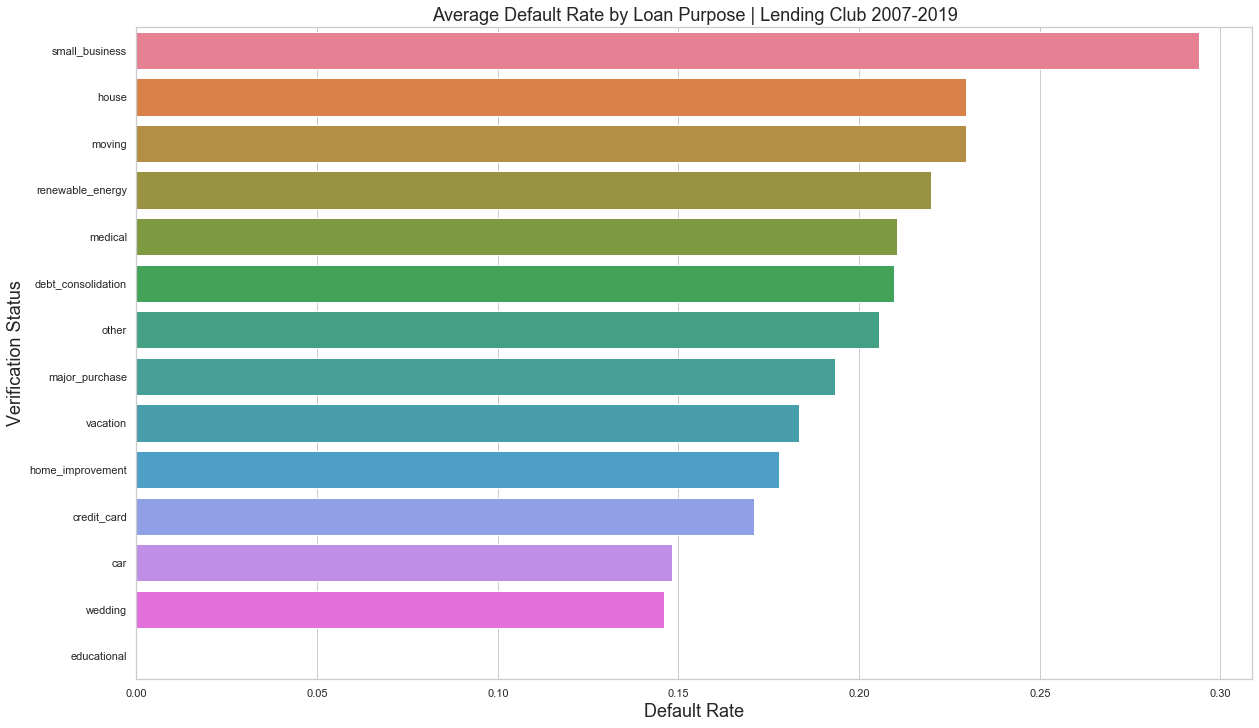

In [47]:
#Default Rate by loan purpose
#Interesting! Startups have the highest risk while wedding the lowest - Hey! They vowed in front of God.

loan_status_by_purpose = lc_all.groupby('purpose').mean().sort_values('Charged Off',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_purpose['Charged Off'], y=loan_status_by_purpose.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Verification Status', fontsize=18)
plt.title("Average Default Rate by Loan Purpose | Lending Club 2007-2019", fontsize=18)
plt.show()

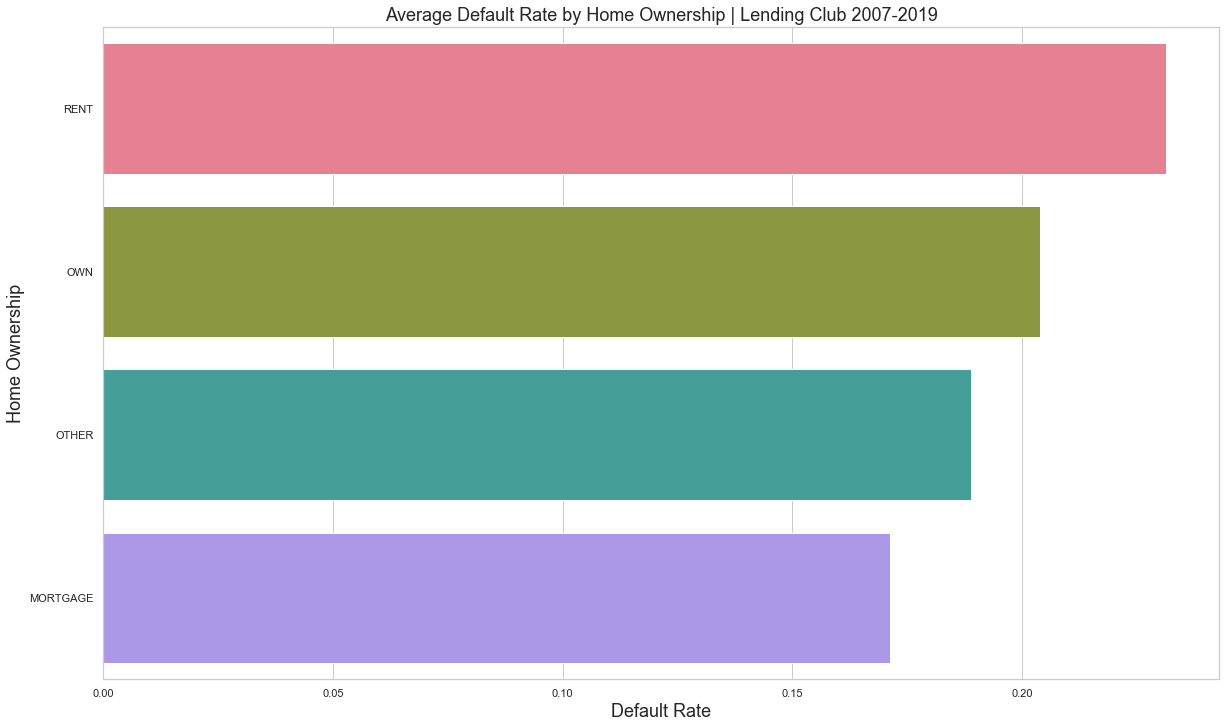

In [48]:
#Default Rate by home ownership

loan_status_by_home = lc_all.groupby('home_ownership').mean().sort_values('Charged Off',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_home['Charged Off'], y=loan_status_by_home.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Home Ownership', fontsize=18)
plt.title("Average Default Rate by Home Ownership | Lending Club 2007-2019", fontsize=18)
plt.show()

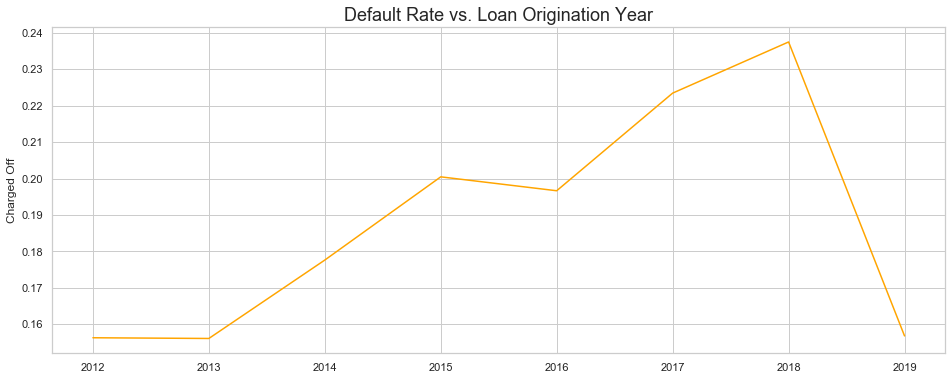

In [49]:
#Default Rate by issue year
#This is very in line with when the scandal was known in 2016

loan_status_by_issue_y = lc_all.groupby('issue_y').mean().sort_values('Charged Off',ascending=False)

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=loan_status_by_issue_y.index, y="Charged Off", data=loan_status_by_issue_y, color='orange')

#plt.xticks(agg_logins_mean.index, rotation=45)
ax.set_xlabel('')
ax.set_title("Default Rate vs. Loan Origination Year", fontsize=18)
plt.show()

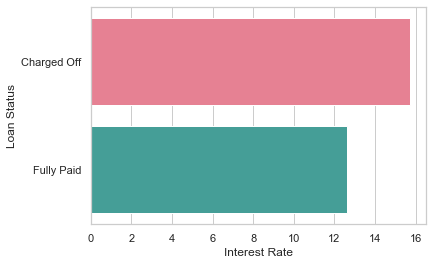

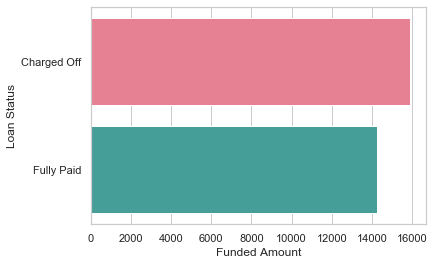

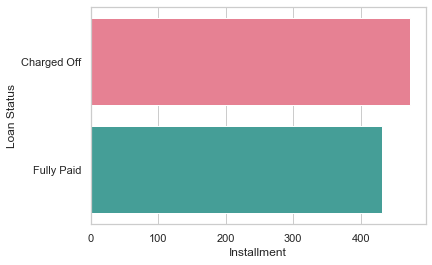

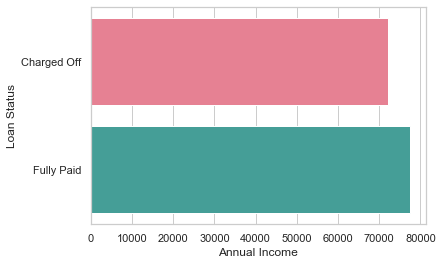

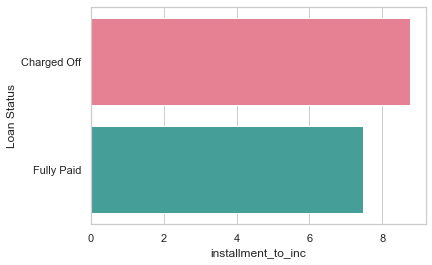

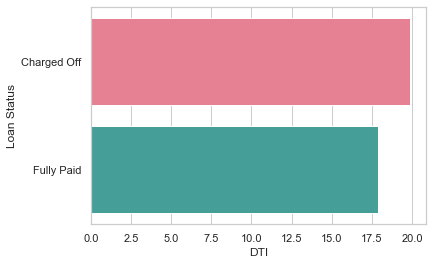

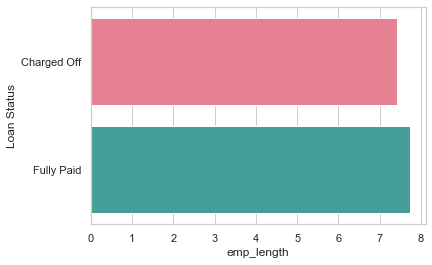

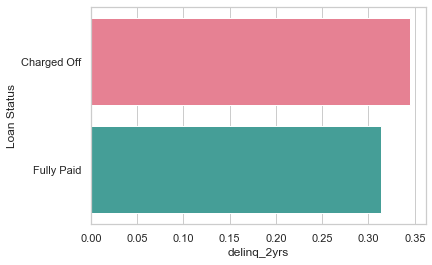

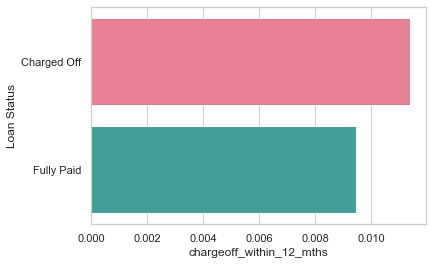

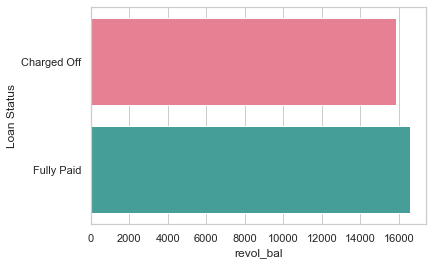

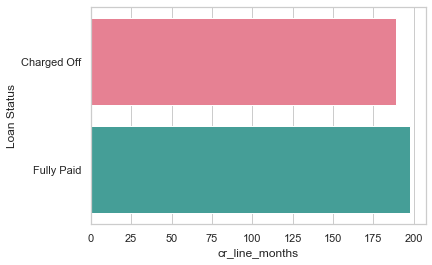

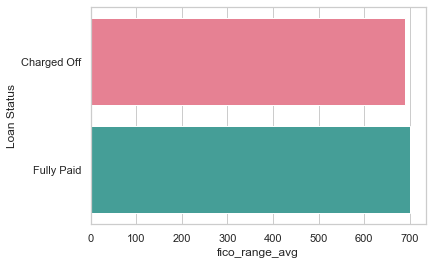

In [50]:
loan_status_mean = lc_all.groupby('loan_status').mean()

#Interest Rate by Loan Status

sns.barplot(x=loan_status_mean.int_rate, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('Interest Rate')
plt.ylabel('Loan Status')
plt.show()

#funded_amnt by Loan Status

sns.barplot(x=loan_status_mean.funded_amnt, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('Funded Amount')
plt.ylabel('Loan Status')
plt.show()

#installment by Loan Status

sns.barplot(x=loan_status_mean.installment, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('Installment')
plt.ylabel('Loan Status')
plt.show()

#annual_inc by Loan Status

sns.barplot(x=loan_status_mean.annual_inc, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('Annual Income')
plt.ylabel('Loan Status')
plt.show()

sns.barplot(x=loan_status_mean.installment_to_inc, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('installment_to_inc')
plt.ylabel('Loan Status')
plt.show()

#dti by Loan Status

sns.barplot(x=loan_status_mean.dti, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('DTI')
plt.ylabel('Loan Status')
plt.show()

#delinq_2yrs by Loan Status

sns.barplot(x=loan_status_mean.emp_length, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('emp_length')
plt.ylabel('Loan Status')
plt.show()

sns.barplot(x=loan_status_mean.delinq_2yrs, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('delinq_2yrs')
plt.ylabel('Loan Status')
plt.show()

sns.barplot(x=loan_status_mean.chargeoff_within_12_mths, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('chargeoff_within_12_mths')
plt.ylabel('Loan Status')
plt.show()

sns.barplot(x=loan_status_mean.revol_bal, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('revol_bal')
plt.ylabel('Loan Status')
plt.show()

sns.barplot(x=loan_status_mean.cr_line_months, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('cr_line_months')
plt.ylabel('Loan Status')
plt.show()

#fico average by Loan Status

sns.barplot(x=loan_status_mean.fico_range_avg, y=loan_status_mean.index, palette = 'husl')
# Add labels to your graph
plt.xlabel('fico_range_avg')
plt.ylabel('Loan Status')
plt.show()


In [51]:
#5 Macroeconomic factors are added: inflation (CPI-U YOY %Chg, Unemployment Rate, 3M T-Bill Rate, 10Y T-Bond Rate, and Industrial Production Index YoY Growth)
#Lags were already applied to inflation, unemployment rate and IP Growth so there're no data leakage.
#If the historical default/lgd/prepayment rate were known, then we could build models to 
#predict them using the time series of these macro factors to account for systematic risks

macro = pd.read_csv("C:\\Users\\armcl\\Python\\Lending Club\\Macro.csv", low_memory=False)
macro['Date'] = pd.to_datetime(macro['Date'])

#Merge the macro data
#lc_all = pd.merge(lc_all, macro, left_on = ['issue_d'], right_on = ['Date'], how='left')

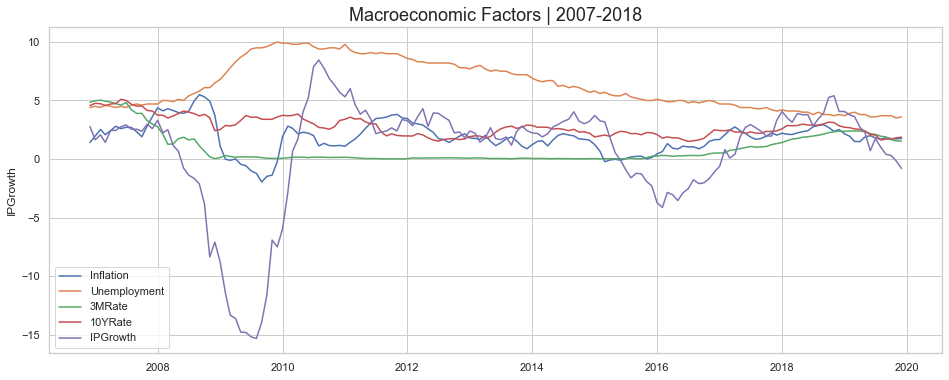

In [52]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=macro['Date'], y="Inflation", label='Inflation', data=macro)
ax = sns.lineplot(x=macro['Date'], y="Unemployment", label='Unemployment', data=macro)
ax = sns.lineplot(x=macro['Date'], y="3MRate", label='3MRate', data=macro)
ax = sns.lineplot(x=macro['Date'], y="10YRate", label='10YRate', data=macro)
ax = sns.lineplot(x=macro['Date'], y="IPGrowth", label='IPGrowth', data=macro)

#plt.xticks(agg_logins_mean.index, rotation=45)
ax.set_xlabel('')
ax.set_title("Macroeconomic Factors | 2007-2018", fontsize=18)
plt.show()

In [53]:
#Remove unneeded features
features_to_remove = ['issue_d','earliest_cr_line','term','addr_state',
                      'sub_grade','home_ownership','verification_status',
                      'purpose','initial_list_status','application_type',
                      'Charged Off','Fully Paid',
                      'fico_range_high','fico_range_low','addr_state']
lc_all = lc_all.drop(columns=features_to_remove)

#Target 
lc_all = lc_all.replace({'loan_status' : {'Fully Paid':0,'Charged Off':1}})


In [54]:
lc_all.head(2)

,funded_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_y,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
42538,11100.0,14.98,384.68,15.0,90000.0,0,3.73,1.0,0.0,9.0,0.0,6619.0,66.2,12.0,0.0,0.0,0.0,353402.0,10000.0,2.0,39267.0,1016.0,74.6,0.0,0.0,1998.0,150.0,11.0,11.0,1.0,11.0,11.0,1.0,4.0,8.0,4.0,4.0,0.0,8.0,11.0,8.0,9.0,1.0,1.0,75.0,50.0,0.0,0.0,385000.0,6619.0,4000.0,0.0,2013,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.0,150.02,692.0,5.129067
42539,12000.0,7.62,373.94,3.0,96500.0,0,12.61,0.0,0.0,17.0,0.0,13248.0,55.7,30.0,0.0,0.0,0.0,200314.0,23800.0,4.0,11783.0,2441.0,83.5,0.0,0.0,123.0,118.0,10.0,9.0,1.0,10.0,10.0,0.0,4.0,5.0,4.0,10.0,15.0,8.0,14.0,5.0,17.0,0.0,3.0,100.0,100.0,0.0,0.0,233004.0,46738.0,14800.0,53404.0,2013,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,186.0,123.01,707.0,4.650031


In [55]:
lc_all.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704569 entries, 42538 to 2778809
Data columns (total 152 columns):
funded_amnt                   1704569 non-null float64
int_rate                      1704569 non-null float64
installment                   1704569 non-null float64
emp_length                    1704569 non-null float64
annual_inc                    1704569 non-null float64
loan_status                   1704569 non-null int64
dti                           1704569 non-null float64
delinq_2yrs                   1704569 non-null float64
inq_last_6mths                1704569 non-null float64
open_acc                      1704569 non-null float64
pub_rec                       1704569 non-null float64
revol_bal                     1704569 non-null float64
revol_util                    1704569 non-null float64
total_acc                     1704569 non-null float64
collections_12_mths_ex_med    1704569 non-null float64
acc_now_delinq                1704569 non-null float64
tot_

In [56]:
lc_all.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_y,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
count,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06,1.704569e+06
mean,1.457032e+04,1.322108e+01,4.402505e+02,7.666440e+00,7.635784e+04,1.985059e-01,1.829348e+01,3.197336e-01,6.119101e-01,1.166614e+01,2.163315e-01,1.642457e+04,5.074994e+01,2.468059e+01,1.958970e-02,4.814707e-03,2.432821e+02,1.385912e+05,3.303470e+04,4.665671e+00,1.328283e+04,1.076122e+04,5.840073e+01,9.836504e-03,1.401277e+01,1.815181e+02,1.803229e+02,1.339350e+01,7.965404e+00,1.599117e+00,2.390477e+01,1.118301e+01,5.110547e-01,3.631288e+00,5.601943e+00,4.739236e+00,7.889284e+00,8.534187e+00,8.252359e+00,1.429739e+01,5.550367e+00,1.161853e+01

In [57]:
lc_all.shape

(1704569, 152)